In [19]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import asarray
from PIL import Image
import pathlib
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from torchvision.transforms import v2
import seaborn as sns
from sklearn.manifold import TSNE

from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#device = "mps" if torch.backends.mps.is_available() else "cpu"

Mounted at /content/drive


In [2]:
# Hyper-parameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

#Model Parameters
num_features = 4

In [3]:
dataset = ImageFolder("/content/drive/MyDrive/plant_leaf_dataset/dataset", transform=Compose(
    [ToTensor(),
     Resize((299, 299)),
     Normalize(mean = [0.4998, 0.5356, 0.4730], std = [0.2194, 0.1735, 0.2318])
    ]))
dataset, testDataset=torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])
trainDataset, validationDataset = torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])

trainingDataLoader = DataLoader(
    trainDataset,
    batch_size=batch_size,
    shuffle=True
)

validationDataLoader = DataLoader(
    validationDataset,
    batch_size=batch_size,
    shuffle=False
)

testingDataLoader = DataLoader(
    testDataset,
    batch_size=batch_size,
    shuffle=False
)

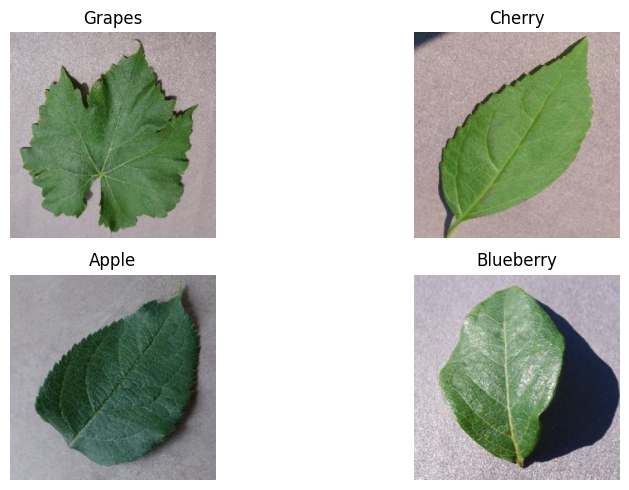

In [4]:

#Plotting images as to display one image per class
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4998, 0.5356, 0.4730])
    std = np.array([0.2194, 0.1735, 0.2318])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

class_names = dataset.dataset.classes

class_images = {}
fig = plt.figure(figsize=(10, 5))
col = int(np.sqrt(len(class_names)))
row = int(np.ceil(len(class_names) / col))

for inputs, classes in trainingDataLoader:
    for i in range(inputs.size(0)):
        class_index = classes[i].item()
        if class_names[class_index] not in class_images:
            class_images[class_names[class_index]] = inputs[i]
            if len(class_images) == len(class_names):
                break
    if len(class_images) == len(class_names):
        break

for i, (class_name, image) in enumerate(class_images.items()):
    ax = fig.add_subplot(row, col, i + 1)
    imshow(image)
    ax.set_title(class_name)

plt.tight_layout()
plt.show()

In [5]:
model = models.inception_v3(weights=None)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_features)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
print(device)

cuda


In [7]:
total_steps = len(trainingDataLoader)

batchwiseTrainAccuracyLog = []
batchwiseTrainLossLog = []

epochwiseTrainAccuracyLog = []
epochwiseTrainLossLog = []

batchwiseValAccuracyLog = []
batchwiseValLossLog = []

epochwiseValAccuracyLog = []
epochwiseValLossLog = []

for epoch in range(num_epochs):

    total_label_count = 0

    accumulated_train_loss=0
    accumulated_validation_loss=0

    accumulated_train_accuracy=0
    accumulated_validation_accuracy=0

    inner_loop_counter_train=0
    model.train()
    for i, data in enumerate(trainingDataLoader):
        inner_loop_counter_train+=1

        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_train_accuracy += (predicted == labels).sum().item()
        accumulated_train_loss+=loss.item()
        if (i + 10) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.7f}, Accuracy: {:.4f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            batchwiseTrainAccuracyLog.append((correct / total) * 100)
            batchwiseTrainLossLog.append(loss.item())
    training_accuracy = accumulated_train_accuracy / total_label_count
    epochwiseTrainAccuracyLog.append(training_accuracy)
    print(f'EPOCH {epoch + 1}.....................')
    print('Accuracy on training set: {}%'.format(100 * training_accuracy))
    epochwiseTrainLossLog.append(accumulated_train_loss/inner_loop_counter_train)

    #Evaluation using validation data

    total_label_count = 0

    inner_loop_counter_validation=0

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(validationDataLoader):
        inner_loop_counter_validation+=1

        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accumulated_validation_accuracy += (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_validation_loss+=loss.item()
        if (i + 1) % 10 == 0:
            batchwiseValAccuracyLog.append((correct / total) * 100)
            batchwiseValLossLog.append(loss.item())
    validation_accuracy = accumulated_validation_accuracy / total_label_count
    epochwiseValAccuracyLog.append(validation_accuracy)
    print('Accuracy on validation set: {}%'.format(100 * validation_accuracy))
    epochwiseValLossLog.append(accumulated_validation_loss/inner_loop_counter_validation)
print("Training Finished!")


Epoch [1/20], Step [1/243], Loss: 1.5157694, Accuracy: 37.5000%
Epoch [1/20], Step [11/243], Loss: 1.4160316, Accuracy: 31.2500%
Epoch [1/20], Step [21/243], Loss: 1.2892158, Accuracy: 34.3750%
Epoch [1/20], Step [31/243], Loss: 1.3216345, Accuracy: 34.3750%
Epoch [1/20], Step [41/243], Loss: 1.2713301, Accuracy: 50.0000%
Epoch [1/20], Step [51/243], Loss: 1.1609236, Accuracy: 59.3750%
Epoch [1/20], Step [61/243], Loss: 1.0807531, Accuracy: 53.1250%
Epoch [1/20], Step [71/243], Loss: 1.1922686, Accuracy: 40.6250%
Epoch [1/20], Step [81/243], Loss: 1.0460821, Accuracy: 59.3750%
Epoch [1/20], Step [91/243], Loss: 1.0211937, Accuracy: 50.0000%
Epoch [1/20], Step [101/243], Loss: 0.8697173, Accuracy: 71.8750%
Epoch [1/20], Step [111/243], Loss: 0.8607194, Accuracy: 65.6250%
Epoch [1/20], Step [121/243], Loss: 0.8474129, Accuracy: 71.8750%
Epoch [1/20], Step [131/243], Loss: 0.7647241, Accuracy: 71.8750%
Epoch [1/20], Step [141/243], Loss: 0.7533398, Accuracy: 84.3750%
Epoch [1/20], Step [1

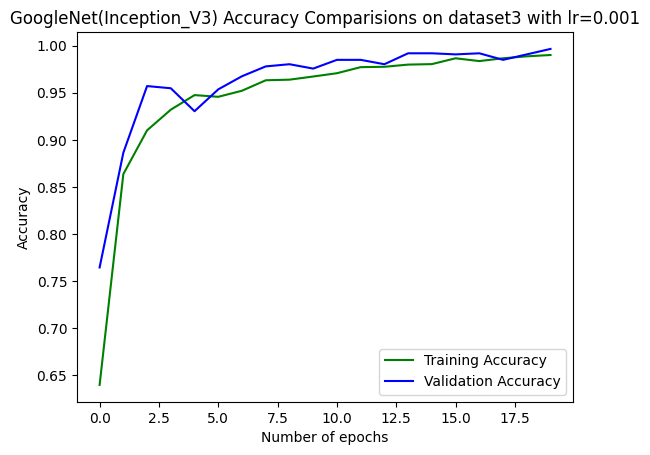

In [20]:
fig,ax=plt.subplots()
epochs_list = list(range(0,20))
ax.plot(epochs_list,epochwiseTrainAccuracyLog,'g',label='Training Accuracy')
ax.plot(epochs_list,epochwiseValAccuracyLog,'b',label='Validation Accuracy')
ax.plot()
ax.set_title('GoogleNet(Inception_V3) Accuracy Comparisions on dataset3 with lr=0.001')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

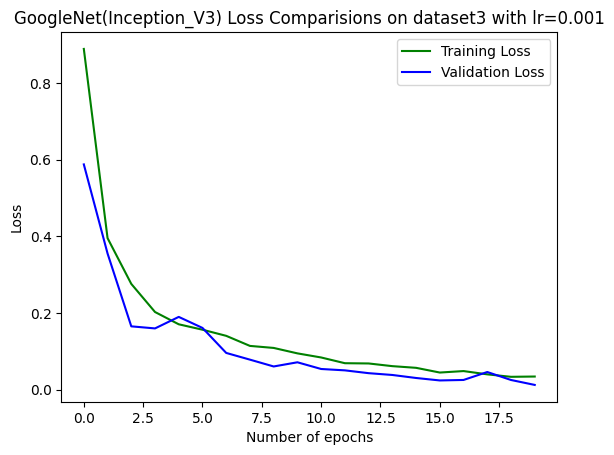

In [21]:
fig,ax=plt.subplots()
ax.plot(epochs_list,epochwiseTrainLossLog,'g',label='Training Loss')
ax.plot(epochs_list,epochwiseValLossLog,'b',label='Validation Loss')
ax.plot()
ax.set_title('GoogleNet(Inception_V3) Loss Comparisions on dataset3 with lr=0.001')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

Accuracy on test set: 99.79338842975206%
Dataset 3 - Test Metrics
Accuracy: 99.79123173277662
Recall: 99.79123173277662
Precision: 
F-score: 99.7912715117605
Confusion Matrix:


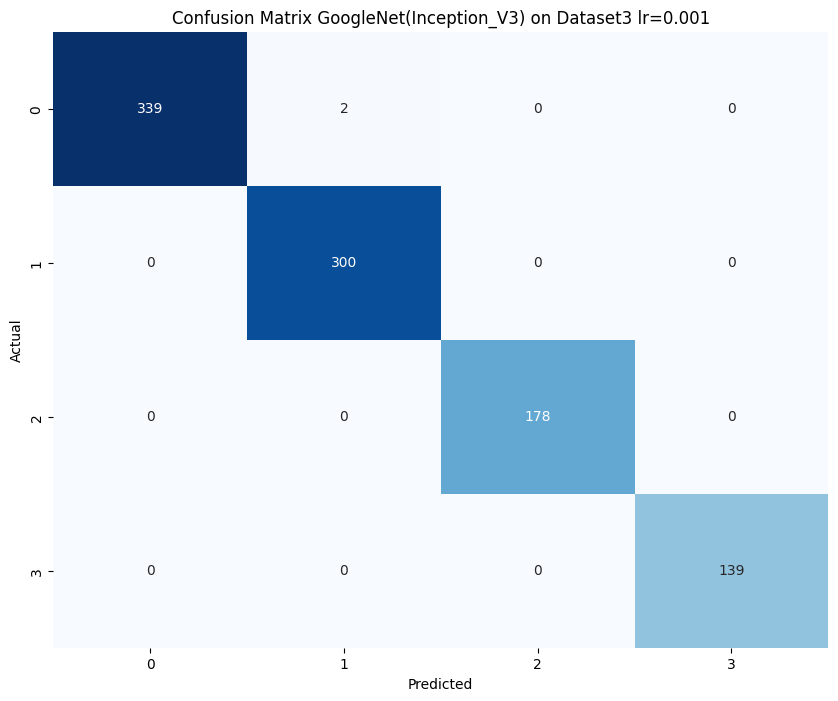

In [22]:
y_pred = []
groundtruth = []

model.eval()

testAccuracyLog = []
testLossLog = []

with torch.no_grad():

    inner_loop_counter_test = 0

    accumulated_test_accuracy=0
    accumulated_test_loss=0

    for images, labels in testingDataLoader:
        images = images.to(device)
        labels = labels.to(device)
        inner_loop_counter_test+=1
        test_loss=0
        outputs = model(images)
        test_loss=criterion(outputs,labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.append(predicted)
        groundtruth.append(labels)
        accumulated_test_loss+=test_loss.item()
    testLossLog.append(accumulated_test_loss/inner_loop_counter_test)
    test_accuracy=correct/total
    print('Accuracy on test set: {}%'.format(100 * test_accuracy))
    testAccuracyLog.append(test_accuracy)

predictions_np = [tensor.detach().cpu().numpy() for tensor in y_pred]
ground_truth_np = [tensor.detach().cpu().numpy() for tensor in groundtruth]

predictions_np = np.concatenate(predictions_np)
ground_truth_np = np.concatenate(ground_truth_np)

accuracy = accuracy_score(ground_truth_np, predictions_np)
recall = recall_score(ground_truth_np, predictions_np, average='weighted')
precision = precision_score(ground_truth_np, predictions_np, average='weighted')
conf_matrix = confusion_matrix(ground_truth_np, predictions_np)
f_score = f1_score(ground_truth_np, predictions_np, average='weighted')

print("Dataset 3 - Test Metrics\nAccuracy:", accuracy*100)
print("Recall:", recall*100)
print("Precision: ".format(precision * 100))
print("F-score:", f_score*100)

print("Confusion Matrix:")

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GoogleNet(Inception_V3) on Dataset3 lr=0.001')
plt.show()

In [23]:
#Plotting Datapoints using TSNE

prediction_list=[]
labels_list=[]
with torch.inference_mode():
  for images, labels in testingDataLoader:
    images=images.to(device)
    labels=labels.to(device)
    outputs = model(images)
    prediction_list.append(outputs.cpu())
    labels_list.append(labels.cpu())

Y_pred=torch.cat(prediction_list).numpy()
y_test=torch.cat(labels_list).numpy()

tsne=TSNE(n_components=2,random_state=42)
embedding_2d=tsne.fit_transform(Y_pred)

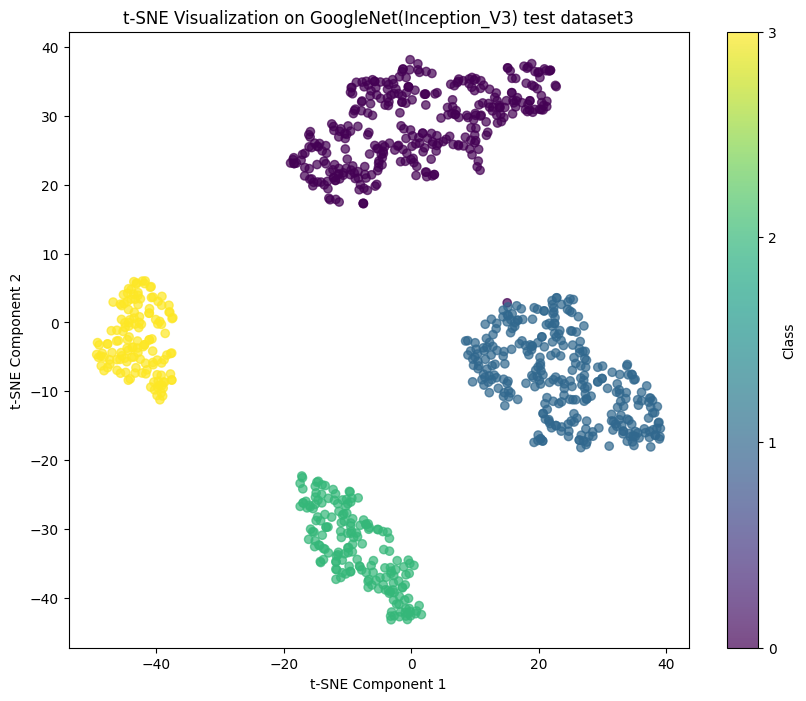

In [24]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter,ticks=[0,1,2,3],label='Class')
plt.title('t-SNE Visualization on GoogleNet(Inception_V3) test dataset3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [13]:

prediction_list=[]
labels_list=[]
with torch.inference_mode():
  for images, labels in trainingDataLoader:
    images=images.to(device)
    labels=labels.to(device)
    outputs = model(images)
    prediction_list.append(outputs.cpu())
    labels_list.append(labels.cpu())

Y_pred=torch.cat(prediction_list).numpy()
y_test=torch.cat(labels_list).numpy()

tsne=TSNE(n_components=2,random_state=42)
embedding_2d=tsne.fit_transform(Y_pred)

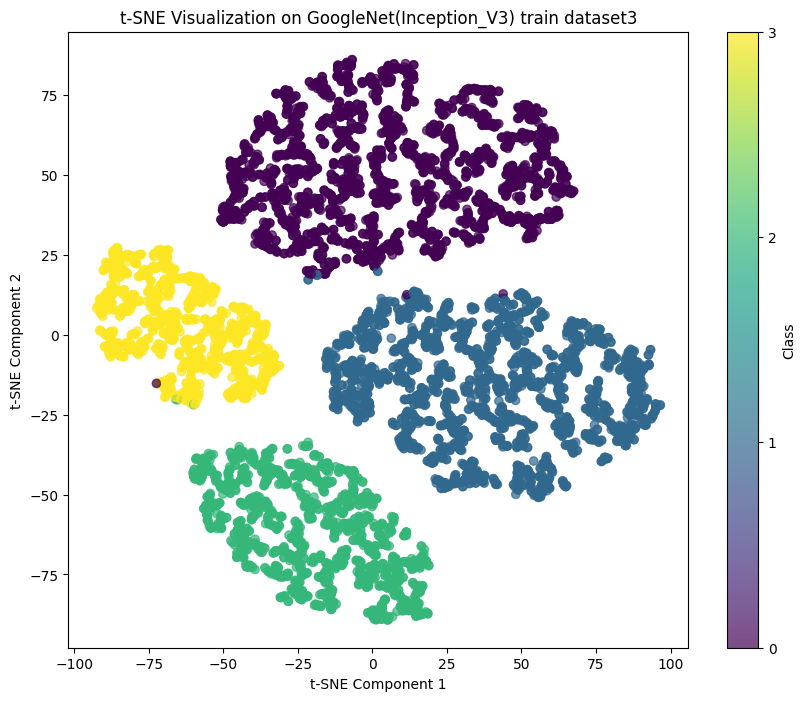

In [17]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter,ticks=[0,1,2,3],label='Class')
plt.title('t-SNE Visualization on GoogleNet(Inception_V3) train dataset3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [15]:
# Saving the model weights for Transfer Learning
torch.save(model.state_dict(), 'GoogleNet(Inception_V3)_Dataset3.pth')